In [379]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import seaborn as sns

In [342]:
train = datasets.MNIST('/', train=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]),
                       download=True)
test = datasets.MNIST('/', train=False, 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))

                        ]),
                      download=True)

def test_acc(model, x, y):
    preds = model(x)
    return (preds.argmax(axis=1) == y).sum() / float(len(y))


In [360]:
batch_size = 256
epochs = 20
max_test_iteration = 25

train_data_loader = DataLoader(train, batch_size=batch_size)
test_data_loader = DataLoader(test, batch_size=batch_size)

In [361]:
state_dicts = []

test_iteration_losses = []
test_iteration_acc = []

for test_iteration in range(max_test_iteration):
    model = nn.Sequential(
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    acc = test_acc(model, test.data.view(-1, 28 * 28).float(), test.targets)
    print(f'Epoch {0} acc {acc:.3f} test {test_iteration}')
    
    for epoch in range(epochs):
        for x, y in tqdm(train_data_loader):
            optimizer.zero_grad()    
            x = x.view(-1, 28 * 28)
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

        acc = test_acc(model, test.data.view(-1, 28 * 28).float(), test.targets)
        print(f'Epoch {epoch} acc {acc:.3f} test {test_iteration}')
    
    test_iteration_losses.append(loss.cpu().item())
    test_iteration_acc.append(acc)
    state_dicts.append(model.state_dict())

Epoch 0 acc 0.082 test 0



Epoch 0 acc 0.812 test 0



Epoch 1 acc 0.826 test 0



Epoch 2 acc 0.832 test 0



Epoch 3 acc 0.838 test 0



Epoch 4 acc 0.845 test 0



Epoch 5 acc 0.851 test 0



Epoch 6 acc 0.859 test 0



Epoch 7 acc 0.867 test 0



Epoch 8 acc 0.875 test 0



Epoch 9 acc 0.883 test 0



Epoch 10 acc 0.889 test 0



Epoch 11 acc 0.896 test 0



Epoch 12 acc 0.901 test 0



Epoch 13 acc 0.906 test 0



Epoch 14 acc 0.911 test 0



Epoch 15 acc 0.915 test 0



Epoch 16 acc 0.920 test 0



Epoch 17 acc 0.923 test 0



Epoch 18 acc 0.926 test 0



Epoch 19 acc 0.929 test 0
Epoch 0 acc 0.094 test 1



Epoch 0 acc 0.804 test 1



Epoch 1 acc 0.818 test 1



Epoch 2 acc 0.824 test 1



Epoch 3 acc 0.833 test 1



Epoch 4 acc 0.841 test 1



Epoch 5 acc 0.850 test 1



Epoch 6 acc 0.859 test 1



Epoch 7 acc 0.866 test 1



Epoch 8 acc 0.875 test 1



Epoch 9 acc 0.882 test 1



Epoch 10 acc 0.889 test 1



Epoch 11 acc 0.896 test 1



Epoch 12 acc 0.901 test 1



Epoch 13 acc 0.905 test 1



Epoch 14 acc 0.910 test 1



Epoch 15 acc 0.914 test 1



Epoch 16 acc 0.917 test 1



Epoch 17 acc 0.920 test 1



Epoch 18 acc 0.923 test 1



Epoch 19 acc 0.926 test 1
Epoch 0 acc 0.082 test 2



Epoch 0 acc 0.815 test 2



Epoch 1 acc 0.827 test 2



Epoch 2 acc 0.832 test 2



Epoch 3 acc 0.839 test 2



Epoch 4 acc 0.847 test 2



Epoch 5 acc 0.854 test 2



Epoch 6 acc 0.861 test 2



Epoch 7 acc 0.869 test 2



Epoch 8 acc 0.876 test 2



Epoch 9 acc 0.882 test 2



Epoch 10 acc 0.888 test 2



Epoch 11 acc 0.893 test 2



Epoch 12 acc 0.900 test 2



Epoch 13 acc 0.903 test 2



Epoch 14 acc 0.908 test 2



Epoch 15 acc 0.912 test 2



Epoch 16 acc 0.916 test 2



Epoch 17 acc 0.920 test 2



Epoch 18 acc 0.923 test 2



Epoch 19 acc 0.925 test 2
Epoch 0 acc 0.103 test 3



Epoch 0 acc 0.815 test 3



Epoch 1 acc 0.825 test 3



Epoch 2 acc 0.828 test 3



Epoch 3 acc 0.833 test 3



Epoch 4 acc 0.840 test 3



Epoch 5 acc 0.847 test 3



Epoch 6 acc 0.855 test 3



Epoch 7 acc 0.865 test 3



Epoch 8 acc 0.873 test 3



Epoch 9 acc 0.881 test 3



Epoch 10 acc 0.886 test 3



Epoch 11 acc 0.892 test 3



Epoch 12 acc 0.897 test 3



Epoch 13 acc 0.902 test 3



Epoch 14 acc 0.906 test 3



Epoch 15 acc 0.910 test 3



Epoch 16 acc 0.914 test 3



Epoch 17 acc 0.918 test 3



Epoch 18 acc 0.921 test 3



Epoch 19 acc 0.924 test 3
Epoch 0 acc 0.093 test 4



Epoch 0 acc 0.808 test 4



Epoch 1 acc 0.822 test 4



Epoch 2 acc 0.830 test 4



Epoch 3 acc 0.839 test 4



Epoch 4 acc 0.849 test 4



Epoch 5 acc 0.855 test 4



Epoch 6 acc 0.865 test 4



Epoch 7 acc 0.871 test 4



Epoch 8 acc 0.878 test 4



Epoch 9 acc 0.885 test 4



Epoch 10 acc 0.891 test 4



Epoch 11 acc 0.896 test 4



Epoch 12 acc 0.902 test 4



Epoch 13 acc 0.906 test 4



Epoch 14 acc 0.910 test 4



Epoch 15 acc 0.914 test 4



Epoch 16 acc 0.917 test 4



Epoch 17 acc 0.921 test 4



Epoch 18 acc 0.924 test 4



Epoch 19 acc 0.927 test 4
Epoch 0 acc 0.097 test 5



Epoch 0 acc 0.817 test 5



Epoch 1 acc 0.825 test 5



Epoch 2 acc 0.828 test 5



Epoch 3 acc 0.833 test 5



Epoch 4 acc 0.840 test 5



Epoch 5 acc 0.847 test 5



Epoch 6 acc 0.855 test 5



Epoch 7 acc 0.863 test 5



Epoch 8 acc 0.869 test 5



Epoch 9 acc 0.876 test 5



Epoch 10 acc 0.883 test 5



Epoch 11 acc 0.888 test 5



Epoch 12 acc 0.894 test 5



Epoch 13 acc 0.899 test 5



Epoch 14 acc 0.904 test 5



Epoch 15 acc 0.909 test 5



Epoch 16 acc 0.912 test 5



Epoch 17 acc 0.917 test 5



Epoch 18 acc 0.920 test 5



Epoch 19 acc 0.924 test 5
Epoch 0 acc 0.094 test 6



Epoch 0 acc 0.815 test 6



Epoch 1 acc 0.820 test 6



Epoch 2 acc 0.824 test 6



Epoch 3 acc 0.832 test 6



Epoch 4 acc 0.838 test 6



Epoch 5 acc 0.848 test 6



Epoch 6 acc 0.857 test 6



Epoch 7 acc 0.865 test 6



Epoch 8 acc 0.873 test 6



Epoch 9 acc 0.880 test 6



Epoch 10 acc 0.885 test 6



Epoch 11 acc 0.893 test 6




Epoch 12 acc 0.898 test 6



Epoch 13 acc 0.904 test 6



Epoch 14 acc 0.909 test 6



Epoch 15 acc 0.913 test 6



Epoch 16 acc 0.918 test 6



Epoch 17 acc 0.922 test 6



Epoch 18 acc 0.926 test 6



Epoch 19 acc 0.928 test 6
Epoch 0 acc 0.103 test 7



Epoch 0 acc 0.811 test 7



Epoch 1 acc 0.816 test 7



Epoch 2 acc 0.821 test 7



Epoch 3 acc 0.829 test 7



Epoch 4 acc 0.838 test 7



Epoch 5 acc 0.847 test 7



Epoch 6 acc 0.854 test 7



Epoch 7 acc 0.863 test 7



Epoch 8 acc 0.870 test 7



Epoch 9 acc 0.877 test 7



Epoch 10 acc 0.883 test 7



Epoch 11 acc 0.888 test 7



Epoch 12 acc 0.894 test 7



Epoch 13 acc 0.900 test 7



Epoch 14 acc 0.905 test 7



Epoch 15 acc 0.908 test 7



Epoch 16 acc 0.913 test 7



Epoch 17 acc 0.916 test 7



Epoch 18 acc 0.920 test 7



Epoch 19 acc 0.924 test 7
Epoch 0 acc 0.096 test 8



Epoch 0 acc 0.822 test 8



Epoch 1 acc 0.830 test 8



Epoch 2 acc 0.835 test 8



Epoch 3 acc 0.839 test 8



Epoch 4 acc 0.845 test 8



Epoch 5 acc 0.852 test 8



Epoch 6 acc 0.859 test 8



Epoch 7 acc 0.866 test 8



Epoch 8 acc 0.873 test 8



Epoch 9 acc 0.879 test 8



Epoch 10 acc 0.885 test 8



Epoch 11 acc 0.890 test 8



Epoch 12 acc 0.897 test 8



Epoch 13 acc 0.902 test 8



Epoch 14 acc 0.906 test 8



Epoch 15 acc 0.909 test 8



Epoch 16 acc 0.912 test 8



Epoch 17 acc 0.914 test 8



Epoch 18 acc 0.917 test 8



Epoch 19 acc 0.920 test 8
Epoch 0 acc 0.130 test 9



Epoch 0 acc 0.832 test 9



Epoch 1 acc 0.841 test 9



Epoch 2 acc 0.844 test 9



Epoch 3 acc 0.851 test 9



Epoch 4 acc 0.856 test 9



Epoch 5 acc 0.863 test 9



Epoch 6 acc 0.871 test 9



Epoch 7 acc 0.876 test 9



Epoch 8 acc 0.883 test 9



Epoch 9 acc 0.888 test 9



Epoch 10 acc 0.893 test 9



Epoch 11 acc 0.899 test 9



Epoch 12 acc 0.905 test 9



Epoch 13 acc 0.910 test 9



Epoch 14 acc 0.914 test 9



Epoch 15 acc 0.918 test 9



Epoch 16 acc 0.921 test 9



Epoch 17 acc 0.924 test 9



Epoch 18 acc 0.926 test 9



Epoch 19 acc 0.928 test 9
Epoch 0 acc 0.090 test 10



Epoch 0 acc 0.822 test 10



Epoch 1 acc 0.834 test 10



Epoch 2 acc 0.844 test 10



Epoch 3 acc 0.850 test 10



Epoch 4 acc 0.858 test 10



Epoch 5 acc 0.866 test 10



Epoch 6 acc 0.872 test 10



Epoch 7 acc 0.879 test 10



Epoch 8 acc 0.883 test 10



Epoch 9 acc 0.889 test 10



Epoch 10 acc 0.894 test 10



Epoch 11 acc 0.900 test 10



Epoch 12 acc 0.906 test 10



Epoch 13 acc 0.909 test 10



Epoch 14 acc 0.913 test 10



Epoch 15 acc 0.918 test 10



Epoch 16 acc 0.921 test 10



Epoch 17 acc 0.925 test 10



Epoch 18 acc 0.928 test 10



Epoch 19 acc 0.930 test 10
Epoch 0 acc 0.091 test 11



Epoch 0 acc 0.800 test 11



Epoch 1 acc 0.812 test 11



Epoch 2 acc 0.818 test 11



Epoch 3 acc 0.826 test 11



Epoch 4 acc 0.834 test 11



Epoch 5 acc 0.841 test 11



Epoch 6 acc 0.849 test 11



Epoch 7 acc 0.857 test 11



Epoch 8 acc 0.866 test 11



Epoch 9 acc 0.873 test 11



Epoch 10 acc 0.878 test 11



Epoch 11 acc 0.886 test 11



Epoch 12 acc 0.891 test 11



Epoch 13 acc 0.897 test 11



Epoch 14 acc 0.904 test 11



Epoch 15 acc 0.907 test 11



Epoch 16 acc 0.911 test 11



Epoch 17 acc 0.915 test 11



Epoch 18 acc 0.920 test 11



Epoch 19 acc 0.923 test 11
Epoch 0 acc 0.124 test 12



Epoch 0 acc 0.828 test 12



Epoch 1 acc 0.833 test 12



Epoch 2 acc 0.838 test 12



Epoch 3 acc 0.843 test 12



Epoch 4 acc 0.850 test 12



Epoch 5 acc 0.856 test 12



Epoch 6 acc 0.863 test 12



Epoch 7 acc 0.870 test 12



Epoch 8 acc 0.878 test 12



Epoch 9 acc 0.885 test 12



Epoch 10 acc 0.890 test 12



Epoch 11 acc 0.896 test 12



Epoch 12 acc 0.903 test 12



Epoch 13 acc 0.908 test 12



Epoch 14 acc 0.912 test 12



Epoch 15 acc 0.916 test 12



Epoch 16 acc 0.920 test 12



Epoch 17 acc 0.923 test 12



Epoch 18 acc 0.926 test 12



Epoch 19 acc 0.928 test 12
Epoch 0 acc 0.138 test 13



Epoch 0 acc 0.830 test 13



Epoch 1 acc 0.831 test 13



Epoch 2 acc 0.830 test 13



Epoch 3 acc 0.832 test 13



Epoch 4 acc 0.838 test 13



Epoch 5 acc 0.844 test 13



Epoch 6 acc 0.852 test 13



Epoch 7 acc 0.860 test 13



Epoch 8 acc 0.870 test 13



Epoch 9 acc 0.878 test 13



Epoch 10 acc 0.885 test 13



Epoch 11 acc 0.889 test 13



Epoch 12 acc 0.895 test 13



Epoch 13 acc 0.900 test 13



Epoch 14 acc 0.905 test 13



Epoch 15 acc 0.910 test 13



Epoch 16 acc 0.913 test 13



Epoch 17 acc 0.917 test 13



Epoch 18 acc 0.920 test 13



Epoch 19 acc 0.922 test 13
Epoch 0 acc 0.129 test 14



Epoch 0 acc 0.814 test 14



Epoch 1 acc 0.823 test 14



Epoch 2 acc 0.828 test 14



Epoch 3 acc 0.839 test 14



Epoch 4 acc 0.846 test 14



Epoch 5 acc 0.854 test 14



Epoch 6 acc 0.863 test 14



Epoch 7 acc 0.871 test 14



Epoch 8 acc 0.879 test 14



Epoch 9 acc 0.886 test 14



Epoch 10 acc 0.892 test 14



Epoch 11 acc 0.898 test 14



Epoch 12 acc 0.904 test 14



Epoch 13 acc 0.908 test 14



Epoch 14 acc 0.911 test 14



Epoch 15 acc 0.914 test 14



Epoch 16 acc 0.919 test 14



Epoch 17 acc 0.922 test 14



Epoch 18 acc 0.925 test 14



Epoch 19 acc 0.928 test 14
Epoch 0 acc 0.077 test 15



Epoch 0 acc 0.822 test 15



Epoch 1 acc 0.826 test 15



Epoch 2 acc 0.831 test 15



Epoch 3 acc 0.838 test 15



Epoch 4 acc 0.845 test 15



Epoch 5 acc 0.853 test 15



Epoch 6 acc 0.863 test 15



Epoch 7 acc 0.872 test 15



Epoch 8 acc 0.880 test 15



Epoch 9 acc 0.888 test 15



Epoch 10 acc 0.896 test 15



Epoch 11 acc 0.902 test 15



Epoch 12 acc 0.907 test 15



Epoch 13 acc 0.913 test 15



Epoch 14 acc 0.917 test 15



Epoch 15 acc 0.920 test 15



Epoch 16 acc 0.923 test 15



Epoch 17 acc 0.926 test 15



Epoch 18 acc 0.929 test 15



Epoch 19 acc 0.933 test 15
Epoch 0 acc 0.095 test 16



Epoch 0 acc 0.804 test 16



Epoch 1 acc 0.816 test 16



Epoch 2 acc 0.825 test 16



Epoch 3 acc 0.833 test 16



Epoch 4 acc 0.840 test 16



Epoch 5 acc 0.846 test 16



Epoch 6 acc 0.854 test 16



Epoch 7 acc 0.860 test 16



Epoch 8 acc 0.868 test 16



Epoch 9 acc 0.873 test 16



Epoch 10 acc 0.879 test 16



Epoch 11 acc 0.886 test 16



Epoch 12 acc 0.894 test 16



Epoch 13 acc 0.898 test 16



Epoch 14 acc 0.903 test 16



Epoch 15 acc 0.907 test 16



Epoch 16 acc 0.911 test 16



Epoch 17 acc 0.915 test 16



Epoch 18 acc 0.919 test 16



Epoch 19 acc 0.922 test 16
Epoch 0 acc 0.097 test 17



Epoch 0 acc 0.811 test 17



Epoch 1 acc 0.825 test 17



Epoch 2 acc 0.833 test 17



Epoch 3 acc 0.843 test 17



Epoch 4 acc 0.852 test 17



Epoch 5 acc 0.861 test 17



Epoch 6 acc 0.869 test 17



Epoch 7 acc 0.877 test 17



Epoch 8 acc 0.885 test 17



Epoch 9 acc 0.891 test 17



Epoch 10 acc 0.899 test 17



Epoch 11 acc 0.903 test 17



Epoch 12 acc 0.908 test 17



Epoch 13 acc 0.914 test 17



Epoch 14 acc 0.918 test 17



Epoch 15 acc 0.922 test 17



Epoch 16 acc 0.925 test 17



Epoch 17 acc 0.929 test 17



Epoch 18 acc 0.932 test 17



Epoch 19 acc 0.934 test 17
Epoch 0 acc 0.075 test 18



Epoch 0 acc 0.807 test 18



Epoch 1 acc 0.817 test 18



Epoch 2 acc 0.823 test 18



Epoch 3 acc 0.830 test 18



Epoch 4 acc 0.839 test 18



Epoch 5 acc 0.847 test 18



Epoch 6 acc 0.856 test 18



Epoch 7 acc 0.867 test 18



Epoch 8 acc 0.874 test 18



Epoch 9 acc 0.883 test 18



Epoch 10 acc 0.889 test 18



Epoch 11 acc 0.895 test 18



Epoch 12 acc 0.900 test 18



Epoch 13 acc 0.905 test 18



Epoch 14 acc 0.910 test 18



Epoch 15 acc 0.914 test 18



Epoch 16 acc 0.919 test 18



Epoch 17 acc 0.922 test 18



Epoch 18 acc 0.925 test 18



Epoch 19 acc 0.927 test 18
Epoch 0 acc 0.071 test 19



Epoch 0 acc 0.811 test 19



Epoch 1 acc 0.829 test 19



Epoch 2 acc 0.838 test 19



Epoch 3 acc 0.846 test 19



Epoch 4 acc 0.854 test 19



Epoch 5 acc 0.861 test 19



Epoch 6 acc 0.868 test 19



Epoch 7 acc 0.875 test 19



Epoch 8 acc 0.883 test 19



Epoch 9 acc 0.889 test 19



Epoch 10 acc 0.895 test 19



Epoch 11 acc 0.901 test 19



Epoch 12 acc 0.905 test 19



Epoch 13 acc 0.909 test 19



Epoch 14 acc 0.913 test 19



Epoch 15 acc 0.916 test 19



Epoch 16 acc 0.920 test 19



Epoch 17 acc 0.923 test 19



Epoch 18 acc 0.926 test 19



Epoch 19 acc 0.928 test 19
Epoch 0 acc 0.115 test 20



Epoch 0 acc 0.818 test 20



Epoch 1 acc 0.827 test 20



Epoch 2 acc 0.832 test 20



Epoch 3 acc 0.837 test 20



Epoch 4 acc 0.844 test 20



Epoch 5 acc 0.850 test 20



Epoch 6 acc 0.858 test 20



Epoch 7 acc 0.864 test 20



Epoch 8 acc 0.871 test 20



Epoch 9 acc 0.877 test 20



Epoch 10 acc 0.883 test 20



Epoch 11 acc 0.889 test 20



Epoch 12 acc 0.895 test 20



Epoch 13 acc 0.900 test 20



Epoch 14 acc 0.905 test 20



Epoch 15 acc 0.910 test 20



Epoch 16 acc 0.915 test 20



Epoch 17 acc 0.919 test 20



Epoch 18 acc 0.923 test 20



Epoch 19 acc 0.925 test 20
Epoch 0 acc 0.087 test 21



Epoch 0 acc 0.805 test 21



Epoch 1 acc 0.813 test 21



Epoch 2 acc 0.820 test 21



Epoch 3 acc 0.826 test 21



Epoch 4 acc 0.836 test 21



Epoch 5 acc 0.843 test 21



Epoch 6 acc 0.852 test 21



Epoch 7 acc 0.859 test 21



Epoch 8 acc 0.866 test 21



Epoch 9 acc 0.874 test 21


KeyboardInterrupt: 

In [362]:
tries = []
for state_dict in state_dicts:
    values = list(state_dict.values())
    flatten_values = []
    for value in values:
        flatten_values.append(value.flatten())
        
    tries.append(np.concatenate(flatten_values).reshape(1, -1))
tries = np.concatenate(tries)

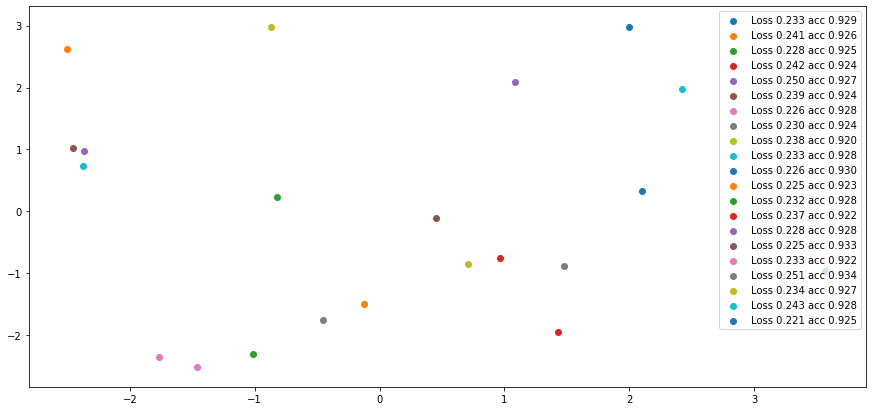

In [363]:
plt.figure(figsize=(15,7))
pca_tries = PCA(2).fit_transform(tries)
for idx,(x,y) in enumerate(pca_tries):
    plt.scatter(x, y, label=f'Loss {test_iteration_losses[idx]:.3f} acc {test_iteration_acc[idx]:.3f}')
    
plt.legend();

In [402]:
pd.DataFrame(pairwise_distances(tries[:10], metric='l2'))

,0,1,2,3,4,5,6,7,8,9
0,0.000000,10.978561,10.985609,10.925866,10.965506,10.953630,10.912281,11.054772,10.996091,10.868649
1,10.978561,0.000000,11.015021,11.026466,10.880653,10.938083,10.932461,11.002429,10.880166,10.980245
2,10.985609,11.015021,0.000000,10.850414,10.865767,10.847239,10.892868,10.978770,10.800041,10.824808
3,10.925866,11.026466,10.850414,0.000000,10.977826,10.985471,10.981323,10.879521,10.918355,10.990623
4,10.965506,10.880653,10.865767,10.977826,0.000000,10.887328,11.049376,11.024796,11.004837,10.936352
5,10.953630,10.938083,10.847239,10.985471,10.887328,0.000000,11.002908,10.864354,10.968165,11.126513
6,10.912281,10.932461,10.892868,10.981323,11.049376,11.002908,0.000000,10.920547,10.995587,11.034803
7,11.054772,11.002429,10.978770,10.879521,11.024796,10.864354,10.920547,0.000000,11.126781,11.103417
8,10.996091,10.880166,10.800041,10.918355,11.004837,10.968165,10.995587,11.126781,0.000000,11.010054
9,10.868649,10.980245,10.824808,10.990623,10.936352,11.126513,11.034803,11.103417,11.010054,0.000000


In [423]:
pd.DataFrame(tries).to_csv('tries.csv')

In [366]:
# plt.imshow(x.view(batch_size,-1)[0].numpy().reshape(28,28))
#np.linalg.norm(tries[9])
pd.DataFrame(pairwise_distances(pca_tries[:10], metric='l2'))

,0,1,2,3,4,5,6,7,8,9
0,0.000000,5.148512,2.931349,1.566733,2.034629,1.708430,4.706602,3.296890,3.983532,1.679586
1,5.148512,0.000000,2.918845,4.835021,3.630400,4.014231,5.018581,4.832244,1.673158,4.969673
2,2.931349,2.918845,0.000000,2.040631,2.663823,1.316996,2.745317,2.022191,2.743603,3.686161
3,1.566733,4.835021,2.040631,0.000000,2.838516,0.829327,3.166881,1.737973,4.151190,3.089528
4,2.034629,3.630400,2.663823,2.838516,0.000000,2.276417,5.273541,4.139327,2.148501,1.341229
5,1.708430,4.014231,1.316996,0.829327,2.276417,0.000000,3.158913,1.886727,3.344932,2.862142
6,4.706602,5.018581,2.745317,3.166881,5.273541,3.158913,0.000000,1.444219,5.396329,6.020792
7,3.296890,4.832244,2.022191,1.737973,4.139327,1.886727,1.444219,0.000000,4.749154,4.709835
8,3.983532,1.673158,2.743603,4.151190,2.148501,3.344932,5.396329,4.749154,0.000000,3.441504
9,1.679586,4.969673,3.686161,3.089528,1.341229,2.862142,6.020792,4.709835,3.441504,0.000000


In [371]:
test_iteration_losses_df = pd.DataFrame(test_iteration_losses)#.to_csv('test_iteration_losses.csv')

In [372]:
test_iteration_acc_df = pd.DataFrame(test_iteration_acc)# .to_csv('test_iteration_acc.csv')

Text(0.5, 0, 'Loss function value')

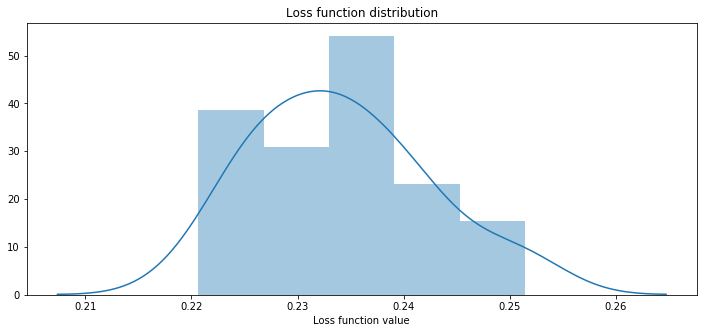

In [399]:
# test_iteration_losses_df.hist(bins=10)
# plt.grid(False)
plt.figure(figsize=(12,5))
sns.distplot(test_iteration_losses_df)
plt.title('Loss function distribution')
plt.xlabel('Loss function value')

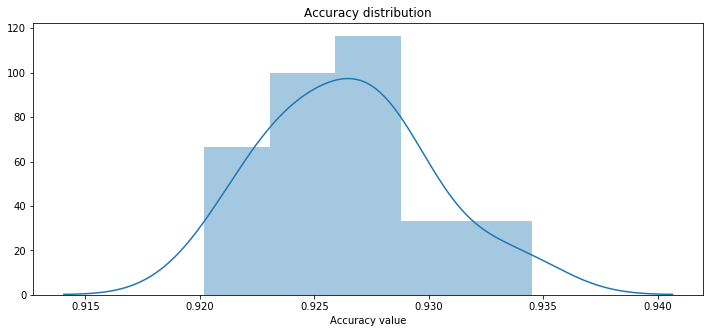

In [401]:
plt.figure(figsize=(12,5))
sns.distplot(test_iteration_acc)
plt.title('Accuracy distribution')
plt.xlabel('Accuracy value');